In [18]:
import pandas as pd
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from config import shuffled_csv, path_exps
from NN import NN_model, Sigmoid, MSE, L2_reg
from NN.utility import batch_train, batch_out, Model_Wrapper
from LBFGS import LBFGS
from testing import multi_run

data = pd.read_csv(shuffled_csv, index_col=0).to_numpy()
data = data[:100, :]
n_samples = data.shape[0]
X_data = data[:, :10]
Y_data = data[:, 10:]

Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y_data)

# np.random.seed(11)
model = NN_model([10, 20, 20, 2], Sigmoid, MSE)
model.init_weights()
reg_loss = L2_reg(1e-4)

# logging.basicConfig(level="INFO")
f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
x = model.Weights


In [22]:
import seaborn as sns
from adam import adam_SGD

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod() ** (1.0 / len(a))

def pair_vector(vector_list):
    maxlen = len(max(vector_list, key=len))
    for i in range(len(vector_list)):
        lastEl = len(vector_list[i]) - 1
        tmpArray = np.full((maxlen - lastEl - 1, 1), vector_list[i][lastEl])
        vector_list[i] = np.array(np.concatenate((vector_list[i], tmpArray), axis=None))
    return vector_list

runs = 3
max_feval = 5000

adam_f_values = []
adam_runtimes = []
adam_f_evals = []

lbfgs_f_values = []
lbfgs_runtimes = []
lbfgs_f_evals = []

for i in range(runs):
    solver = adam_SGD(max_feval = max_feval)
    model.init_weights()
    x = model.Weights

    start_time = time.process_time()
    status = solver.solve(f, x)
    end_time = time.process_time()
    runtime = end_time-start_time
    adam_runtimes.append(runtime)

    adam_f_evals.append(solver.feval)
    adam_f_values.append(solver.f_values)

for i in range(runs):
    solver = LBFGS(eps=1e-10,max_feval=max_feval,M=500,m1=0.01,m2=0.7)
    model.init_weights()
    x = model.Weights

    start_time = time.process_time()
    status = solver.solve(f, x)
    end_time = time.process_time()
    runtime = end_time-start_time
    lbfgs_runtimes.append(runtime)

    lbfgs_f_values.append(solver.f_values)
    lbfgs_f_evals.append(solver.feval)

print("Solver \t\tMean runtime\t\tvariance runtime")
print(f"ADAM\t\t{np.mean(adam_runtimes)}\t{np.var(adam_runtimes)}")
print(f"LBFGS\t\t{np.mean(lbfgs_runtimes)}\t{np.var(lbfgs_runtimes)}")

Solver 		Mean runtime		variance runtime
ADAM		56.05905033333298	0.929593070001758
LBFGS		91.0446113333334	5.106076393716459


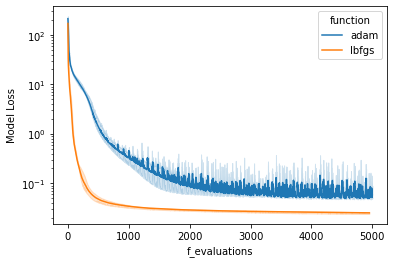

In [23]:
if lbfgs_f_values is not None and adam_f_values is not None: 
    run_1 = pair_vector(adam_f_values)
    run_2 = pair_vector(lbfgs_f_values)
    df_1 = pd.DataFrame(run_1).melt()
    df_1['function'] = ["adam"] * len(df_1.index)
    df_2 = pd.DataFrame(run_2).melt()
    df_2['function'] = ["lbfgs"] * len(df_2.index)
    result = pd.concat([df_1, df_2], axis=0)
    
    # Plot fevals
    fig = sns.lineplot(x="variable", y="value", hue="function", data=result, estimator=geo_mean)
    fig.set_yscale("log")
    fig.set(xlabel='f_evaluations', ylabel='Model Loss')

Computing Level Method 1
LevelMethodException Warning: Negative gap -0.00042936583142338947
Computing Level Method 2
LevelMethodException Warning: Negative gap -0.00017965231584682329
Computing Level Method 3
LevelMethodException Warning: Negative gap -0.694351031025235
Computing Level Method 4
LevelMethodException Warning: Negative gap -0.002106361110520538
Computing Level Method 5
LevelMethodException Warning: Negative gap -5.120737621044924e-06
Computing ADAM 1
Computing ADAM 2
Computing ADAM 3
Computing ADAM 4
Computing ADAM 5
Solver 		Mean runtime		variance runtime
ADAM		12.425	0.00072265625
Level		55.715625	1205.04212890625


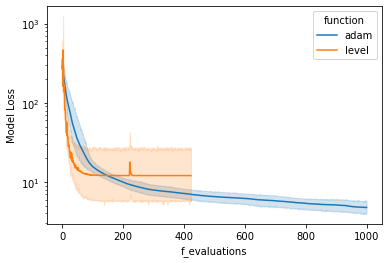

In [8]:
# Adam vs Level Bundle

from NN import ReLU, L1_reg

import seaborn as sns
from adam import adam_SGD
from LevelMethod import LevelMethod

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod() ** (1.0 / len(a))

def pair_vector(vector_list):
    maxlen = len(max(vector_list, key=len))
    for i in range(len(vector_list)):
        lastEl = len(vector_list[i]) - 1
        tmpArray = np.full((maxlen - lastEl - 1, 1), vector_list[i][lastEl])
        vector_list[i] = np.array(np.concatenate((vector_list[i], tmpArray), axis=None))
    return vector_list

models = [[10, 5, 5, 2]]
names = ["5"]
for i in range(len(models)):
    model = models[i]
    name = names[i]
    model = NN_model(model, ReLU, MSE)
    model.init_weights()
    reg_l20ss = L1_reg(1e-4)

    # logging.basicConfig(level="INFO")
    f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
    x = model.Weights

    runs = 5
    max_feval = 1000

    adam_f_values = []
    adam_runtimes = []
    adam_f_evals = []

    level_f_values = []
    level_runtimes = []
    level_f_evals = []

    for i in range(runs):
        print(f"Computing Level Method {i+1}")
        solver = LevelMethod(lambda_=0.7,bounds=1,max_iter=max_feval,verbose=False,epsilon=0.00001)
        model.init_weights()
        x = model.Weights

        start_time = time.process_time()
        status = solver.solve(f, x)
        end_time = time.process_time()
        runtime = end_time-start_time
        level_runtimes.append(runtime)

        level_f_values.append(solver.f_values)
        level_f_evals.append(solver.feval)

    for i in range(runs):
        print(f"Computing ADAM {i+1}")
        solver = adam_SGD(max_feval = max_feval)
        model.init_weights()
        x = model.Weights

        start_time = time.process_time()
        status = solver.solve(f, x)
        end_time = time.process_time()
        runtime = end_time-start_time
        adam_runtimes.append(runtime)

        adam_f_evals.append(solver.feval)
        adam_f_values.append(solver.f_values)

    print("Solver \t\tMean runtime\t\tvariance runtime")
    print(f"ADAM\t\t{np.mean(adam_runtimes)}\t{np.var(adam_runtimes)}")
    print(f"Level\t\t{np.mean(level_runtimes)}\t{np.var(level_runtimes)}")

    if level_f_values is not None and adam_f_values is not None: 
        run_1 = pair_vector(adam_f_values)
        run_2 = pair_vector(level_f_values)
        df_1 = pd.DataFrame(run_1).melt()
        df_1['function'] = ["adam"] * len(df_1.index)
        df_2 = pd.DataFrame(run_2).melt()
        df_2['function'] = ["level"] * len(df_2.index)
        result = pd.concat([df_1, df_2], axis=0)
        
        # Plot fevals
        fig = sns.lineplot(x="variable", y="value", hue="function", data=result, estimator=geo_mean)
        fig.set_yscale("log")
        fig.set(xlabel='f_evaluations', ylabel='Model Loss')

In [10]:

fig.get_figure().savefig('plots/level/comparison' + name + '_fail.png')